### References:
- [data](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)
- [code reference](https://www.kaggle.com/code/ahedjneed/skin-cancer-classifier-with-fastai-acc-97)
- [another code reference](https://www.kaggle.com/code/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app)
- [data description](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)
- [paper](https://arxiv.org/abs/1902.03368)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import shutil

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

glob.glob('../input/skin-cancer-mnist-ham10000/*')

['../input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv',
 '../input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv',
 '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
 '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1',
 '../input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv',
 '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2',
 '../input/skin-cancer-mnist-ham10000/ham10000_images_part_2',
 '../input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv',
 '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv']

In [2]:
images_path = glob.glob('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/*')
img_id = []

for i in images_path:
    img_id.append(i.split('/')[4].split('.')[0])

In [3]:
img_id[:10]

['ISIC_0028933',
 'ISIC_0028394',
 'ISIC_0027799',
 'ISIC_0028100',
 'ISIC_0027960',
 'ISIC_0028872',
 'ISIC_0026412',
 'ISIC_0024872',
 'ISIC_0026232',
 'ISIC_0027031']

In [4]:
data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
data['lesion_id'].nunique()

7470

In [7]:
data.duplicated(subset=['lesion_id']).value_counts()

False    7470
True     2545
dtype: int64

In [8]:
# How many images associated with lesion_id
df_data = data.groupby('lesion_id').count()
df_data

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1
...,...,...,...,...,...,...
HAM_0007624,1,1,1,1,1,1
HAM_0007625,2,2,2,2,2,2
HAM_0007626,1,1,1,1,1,1


In [9]:
df_data = df_data[df_data['image_id']==1]
df_data.sample(7)

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0002241,1,1,1,1,1,1
HAM_0006286,1,1,1,1,1,1
HAM_0006155,1,1,1,1,1,1
HAM_0006532,1,1,1,1,1,1
HAM_0002437,1,1,1,1,1,1
HAM_0003318,1,1,1,1,1,1
HAM_0002466,1,1,1,1,1,1


In [10]:
df_data.reset_index(inplace=True)
df_data.sample(7)

,lesion_id,image_id,dx,dx_type,age,sex,localization
3288,HAM_0004504,1,1,1,1,1,1
4456,HAM_0006172,1,1,1,1,1,1
2556,HAM_0003517,1,1,1,1,1,1
2620,HAM_0003600,1,1,1,1,1,1
1237,HAM_0001657,1,1,1,1,1,1
5369,HAM_0007416,1,1,1,1,1,1
2241,HAM_0003058,1,1,1,1,1,1


In [11]:
def identify_duplicates(x):
    lesion_id = list(df_data['lesion_id'])
    
    if x in lesion_id:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
data['duplicates'] = data['lesion_id']
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM_0000118
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM_0000118
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM_0002730
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM_0002730
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM_0001466


In [12]:
data['duplicates'] = data['duplicates'].apply(identify_duplicates)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [13]:
data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [14]:
# Lets filter data that doesn't have duplicates
df = data[data['duplicates']=='no_duplicates']
print(df.shape)
display(df.sample(4))

(5514, 8)


,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
3062,HAM_0007236,ISIC_0027278,nv,follow_up,55.0,male,lower extremity,no_duplicates
4495,HAM_0001019,ISIC_0026377,nv,follow_up,75.0,female,upper extremity,no_duplicates
916,HAM_0006277,ISIC_0031428,bkl,consensus,55.0,male,scalp,no_duplicates
4480,HAM_0005430,ISIC_0024990,nv,follow_up,60.0,female,trunk,no_duplicates


In [15]:
y = df['dx']
_, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

In [16]:
df_val.shape

(1103, 8)

In [17]:
df_val.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
5848,HAM_0007134,ISIC_0026394,nv,follow_up,60.0,male,abdomen,no_duplicates
4851,HAM_0003571,ISIC_0026602,nv,follow_up,50.0,female,trunk,no_duplicates
7989,HAM_0004189,ISIC_0033036,nv,histo,40.0,female,unknown,no_duplicates
9143,HAM_0002172,ISIC_0024416,nv,histo,65.0,female,back,no_duplicates
6536,HAM_0001901,ISIC_0026274,nv,follow_up,40.0,female,trunk,no_duplicates


In [18]:
df_val['dx'].value_counts(normalize=True)

nv       0.800544
bkl      0.079782
mel      0.041704
bcc      0.031732
akiec    0.027199
vasc     0.011786
df       0.007253
Name: dx, dtype: float64

In [19]:
df['dx'].value_counts(normalize=True)

nv       0.800689
bkl      0.079797
mel      0.041712
bcc      0.031737
akiec    0.027385
vasc     0.011607
df       0.007073
Name: dx, dtype: float64

In [20]:
def identify_val(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
    
data['train_or_val'] = data['image_id']
data['train_or_val'] = data['train_or_val'].apply(identify_val)
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
2588,HAM_0003186,ISIC_0027297,bcc,histo,70.0,male,face,no_duplicates,train
7870,HAM_0006182,ISIC_0033789,nv,histo,35.0,male,abdomen,has_duplicates,train
2749,HAM_0000612,ISIC_0026968,bcc,histo,75.0,female,neck,no_duplicates,train
7820,HAM_0003447,ISIC_0032703,nv,histo,65.0,male,abdomen,has_duplicates,train
9278,HAM_0002795,ISIC_0032312,nv,consensus,30.0,female,back,has_duplicates,train


In [21]:
# Filter train rows
df_train = data[data['train_or_val']=='train']
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train


In [22]:
print(len(df_train))
print(len(df_val))

8912
1103


In [23]:
df_train['dx'].value_counts(normalize=True)

nv       0.653276
mel      0.119726
bkl      0.113443
bcc      0.053748
akiec    0.033326
vasc     0.014475
df       0.012006
Name: dx, dtype: float64

In [24]:
df_val['dx'].value_counts(normalize=True)

nv       0.800544
bkl      0.079782
mel      0.041704
bcc      0.031732
akiec    0.027199
vasc     0.011786
df       0.007253
Name: dx, dtype: float64

In [25]:
folder1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
folder2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')

In [26]:
folder2[:5]

['ISIC_0030912.jpg',
 'ISIC_0030585.jpg',
 'ISIC_0033697.jpg',
 'ISIC_0030062.jpg',
 'ISIC_0031213.jpg']

In [27]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [28]:
val_list[:5]

['ISIC_0026394',
 'ISIC_0026602',
 'ISIC_0033036',
 'ISIC_0024416',
 'ISIC_0026274']

In [29]:
# Create new directory
os.mkdir('base_dir')

# now I will create 7 folders inside base_dir

# train
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    
# val
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

In [30]:
train_dir = os.path.join('./base_dir', 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join('./base_dir', 'val_dir')
os.mkdir(val_dir)

In [31]:
classes = list(data['dx'].unique())

for i in classes:
    dire = os.path.join('./base_dir/train_dir', i)
    os.mkdir(dire)
    
    dire = os.path.join('./base_dir/val_dir', i)
    os.mkdir(dire)

In [32]:
os.listdir('./base_dir/train_dir')

['bkl', 'bcc', 'df', 'vasc', 'akiec', 'mel', 'nv']

In [33]:
data.set_index('image_id', inplace=True)
data.head()

,lesion_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train


In [34]:
data.loc['ISIC_0026769', 'dx']

'bkl'

In [35]:
# To make sure that there are no duplicates
set(folder1).intersection(set(folder2))

set()

In [36]:
train_list[:5]

['ISIC_0027419',
 'ISIC_0025030',
 'ISIC_0026769',
 'ISIC_0025661',
 'ISIC_0031633']

In [37]:
for image in train_list:
    fname = image+'.jpg'
    label = data.loc[image, 'dx']

    if fname in folder1:
        src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', fname)
        dis = os.path.join(train_dir, label, fname)

        shutil.copyfile(src, dis)
        
    if fname in folder2:
        src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', fname)
        dis = os.path.join(train_dir, label, fname)

        shutil.copyfile(src, dis)

# -----------------------------------------------------------------------

for image in val_list:
    fname = image+'.jpg'
    label = data.loc[image, 'dx']

    if fname in folder1:
        src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', fname)
        dis = os.path.join(val_dir, label, fname)

        shutil.copyfile(src, dis)
        
    if fname in folder2:
        src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', fname)
        dis = os.path.join(val_dir, label, fname)

        shutil.copyfile(src, dis)


In [38]:
os.listdir('./base_dir/train_dir/bcc')[:5]

['ISIC_0033054.jpg',
 'ISIC_0031824.jpg',
 'ISIC_0025433.jpg',
 'ISIC_0028147.jpg',
 'ISIC_0031531.jpg']

In [39]:
os.listdir(val_dir)

['bkl', 'bcc', 'df', 'vasc', 'akiec', 'mel', 'nv']

In [40]:
for i in classes:
    dire = os.path.join(train_dir, i)
    print(f'Num images in {i} in train folder : {len(os.listdir(dire))}')
    
    dire = os.path.join(val_dir, i)
    print(f'Num images in {i} in val folder : {len(os.listdir(dire))}', end='\n\n')
    

Num images in bkl in train folder : 1011
Num images in bkl in val folder : 88

Num images in nv in train folder : 5822
Num images in nv in val folder : 883

Num images in df in train folder : 107
Num images in df in val folder : 8

Num images in mel in train folder : 1067
Num images in mel in val folder : 46

Num images in vasc in train folder : 129
Num images in vasc in val folder : 13

Num images in bcc in train folder : 479
Num images in bcc in val folder : 35

Num images in akiec in train folder : 297
Num images in akiec in val folder : 30



In [41]:
train_dir, val_dir

('./base_dir/train_dir', './base_dir/val_dir')

In [42]:
data_gen = ImageDataGenerator(rescale=1/255.0,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=180)

batch_size = 50

train_gen = data_gen.flow_from_directory(train_dir, batch_size=batch_size,
                                        target_size=(224,224), class_mode='categorical')


val_data_gen = ImageDataGenerator(rescale=1/255.0,)
val_gen = val_data_gen.flow_from_directory(val_dir, batch_size=batch_size,
                                        target_size=(224,224), class_mode='categorical')

Found 8912 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (224,224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2), 
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(5,5), 
    tf.keras.layers.Dropout(0.2), 
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    
    tf.keras.layers.Flatten(), 
    
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

2022-09-08 15:23:56.334472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:23:56.493312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:23:56.494177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:23:56.496189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0

In [ ]:
model.compile(loss='categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [51]:
early_stoping = tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_acc', restore_best_weights=True)
check_point = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [ ]:
# history = model.fit_generator(train_gen, epochs=20, validation_data=val_gen, steps_per_epoch =150 , 
#                               callbacks=[early_stoping, check_point])

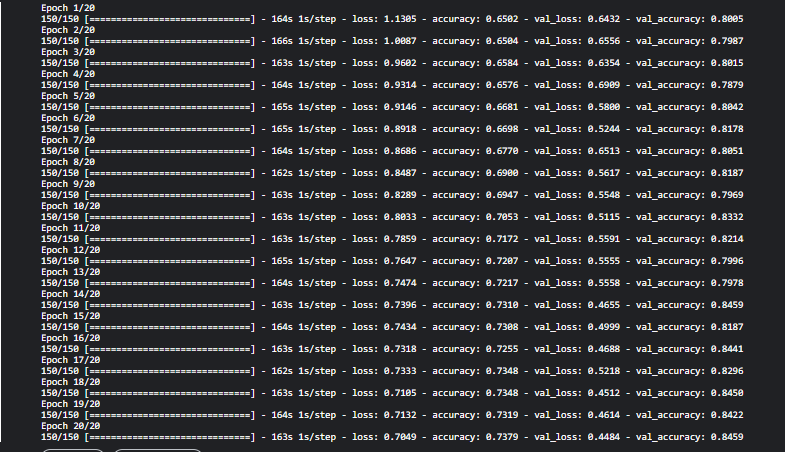

In [ ]:
# Now, we can use the best model which has the better val_accuracy
#model.load_weights('./best_model.h5')

In [ ]:
#history.history.keys()

In [ ]:
# plt.figure(figsize=(20,7))
# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# plt.subplot(1,2,2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

In [44]:
# Let's try a pretrained model
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 655.3 kB/s eta 0:00:00 0:00:01


In [45]:
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(244,244,3))

2022-10-27 09:35:15.755067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 09:35:15.854177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 09:35:15.854982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 09:35:15.856872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

31948800/31936256 [==============================] - 3s 0us/step


In [46]:
base_model.input

<KerasTensor: shape=(None, 244, 244, 3) dtype=float32 (created by layer 'input_1')>

In [47]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 1408) dtype=float32 (created by layer 'top_activation')>

In [48]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(7, activation='softmax')(x)

model_ = tf.keras.Model(inputs=base_model.input, outputs=out)

In [49]:
model_.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [52]:
model_.fit_generator(train_gen, epochs=30, validation_data=val_gen, steps_per_epoch =100 , 
                               callbacks=[early_stoping])

Epoch 1/30
100/100 [==============================] - 134s 1s/step - loss: 0.7038 - accuracy: 0.7529 - val_loss: 1.0435 - val_accuracy: 0.8024
Epoch 2/30
100/100 [==============================] - 129s 1s/step - loss: 0.5548 - accuracy: 0.7997 - val_loss: 0.6711 - val_accuracy: 0.8286
Epoch 3/30
100/100 [==============================] - 128s 1s/step - loss: 0.5150 - accuracy: 0.8089 - val_loss: 0.4252 - val_accuracy: 0.8794
Epoch 4/30
100/100 [==============================] - 127s 1s/step - loss: 0.4635 - accuracy: 0.8271 - val_loss: 0.4932 - val_accuracy: 0.8586
Epoch 5/30
100/100 [==============================] - 127s 1s/step - loss: 0.4517 - accuracy: 0.8307 - val_loss: 0.3656 - val_accuracy: 0.8885
Epoch 6/30
100/100 [==============================] - 130s 1s/step - loss: 0.4166 - accuracy: 0.8450 - val_loss: 0.4087 - val_accuracy: 0.8740
Epoch 7/30
100/100 [==============================] - 128s 1s/step - loss: 0.3908 - accuracy: 0.8609 - val_loss: 0.6138 - val_accuracy: 0.7752

In [54]:
model_.evaluate(val_gen)

23/23 [==============================] - 13s 556ms/step - loss: 0.5876 - accuracy: 0.8613


[0.5876185894012451, 0.8612874150276184]

In [55]:
model_.evaluate(train_gen)

179/179 [==============================] - 181s 1s/step - loss: 0.1498 - accuracy: 0.9456


[0.14979170262813568, 0.9455789923667908]

In [60]:
glob.glob('./base_dir/val_dir/mel/*')[8]

'./base_dir/val_dir/mel/ISIC_0028220.jpg'

In [78]:
class_indices = {v:k for k, v in train_gen.class_indices.items()}

In [81]:
full_name_cancer_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

In [83]:
val_paths = glob.glob('./base_dir/val_dir/*')
val_paths

['./base_dir/val_dir/bkl',
 './base_dir/val_dir/bcc',
 './base_dir/val_dir/df',
 './base_dir/val_dir/vasc',
 './base_dir/val_dir/akiec',
 './base_dir/val_dir/mel',
 './base_dir/val_dir/nv']

In [95]:
def predict(num, path, model_name):
    true_labels = []
    predicted_labels = []
    acc = 0
    
    for i in range(num):
        fp = np.random.choice(path, size=1)[0]
        true_label = full_name_cancer_dict[fp.split('/')[-1]]
        true_labels.append(true_label)
        test_img = plt.imread(np.random.choice(glob.glob(fp+'/*'), size=1, replace=False)[0])
        
        test_img = test_img/255.0
        test_img = tf.image.resize(test_img, (244, 244))
        test_img = np.expand_dims(test_img, axis=0)

        pred = model_name.predict(test_img)
        pred_label = full_name_cancer_dict[class_indices[np.argmax(pred)]]
        predicted_labels.append(pred_label)
        
        if true_label == pred_label:
            acc+=1
        
    print(f'Acc : {acc/num*100}%')
    return pd.DataFrame({'True Labels':true_labels, 'Predicted Labels':predicted_labels})

In [99]:
predict(30, val_paths, model_)

Acc : 80.0%


,True Labels,Predicted Labels
0,vascular lesions,vascular lesions
1,dermatofibroma,dermatofibroma
2,basal cell carcinoma,basal cell carcinoma
3,melanocytic nevi,melanocytic nevi
4,basal cell carcinoma,basal cell carcinoma
5,benign keratosis-like lesions,benign keratosis-like lesions
6,dermatofibroma,dermatofibroma
7,melanocytic nevi,basal cell carcinoma
8,vascular lesions,vascular lesions
9,basal cell carcinoma,basal cell carcinoma
